In [1]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from netket.models.slater import Slater2nd
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from models_old import get_qwz_graph, get_debug_Ham
from netket_qwz_system import NetketQWZSystem
from networks import *
from helper import get_ed_data

In [2]:
L = 2
Lx = 2*L
Ly = L
N = Lx * Ly//2
pbc = True
complex = True

#graph, hi = get_qwz_graph(L = Lx, L2 = Ly, pbc = pbc, N = N)

m = 5.0
t = 1.0
U = 8.0
s = 0
p = 1
bias = 1e-5
learning_rate = 0.01
diag_shift = 0.01

args = {'U': U, 't': t, 'm': m, 'bias': bias, 'complex': complex}

system = NetketQWZSystem(L = Lx, L2 = Ly, N = N, pbc = pbc, args = args)

Ham = system.get_qwz_hamiltonian()

hi = system.hi
exchange_graph = system.get_exchange_graph()

# Exact diagonalization

evals, evecs = get_ed_data(Ham, k = 6)
E_gs = evals[0]

Exact ground state energy: -28.46253810921251


In [11]:
s, p = 1, -1
def corr_func(i):
    return cdag(hi, i, s) * c(hi, 0, s) + cdag(hi, i, p) * c(hi, 0, p)

In [12]:
corrs = {}
for i in range(N):
    corrs[f"cdag{i}c0"] = corr_func(i)

# Slater Determinant

In [13]:
n_iter = 300
# Create the Slater determinant model
model = LogSlaterDeterminant(hi, complex = complex)#Slater2nd(hi, generalized=True)#LogSlaterDeterminant(hi)

# Define the Metropolis-Hastings sampler
sa = nk.sampler.ExactSampler(hi) 
#sa = nk.sampler.MetropolisLocal(hi)
#sa = nk.sampler.MetropolisExchange(hi, graph=exchange_graph)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic=complex)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(Ham, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=slater_log, obs = corrs)

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['cdag0c0', 'cdag1c0', 'cdag2c0', 'cdag3c0', 'Energy'],)

In [14]:
sd_energy = vstate.expect(Ham)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -28.3939-0.0014j ± 0.0090 [σ²=0.3522]
Relative error   : 0.0011148581912616268


In [7]:
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic=complex)

In [8]:
# Create a Neural Jastrow Slater wave function 
model = LogNeuralJastrowSlater(hi, hidden_units=N, complex=complex)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
gs = nk.VMC(Ham, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=nj_log)

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/5000 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['Energy'],)

In [9]:
sd_energy = vstate.expect(Ham)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -28.3914-0.0028j ± 0.0074 [σ²=0.2556]
Relative error   : 0.0012067910966072376


In [ ]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N, complex=complex)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
gs = nk.VMC(Ham, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=bf_log)

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/5000 [00:00<?, ?it/s]

In [20]:
sd_energy = vstate.expect(Ham)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -28.383-0.001j ± 0.011 [σ²=0.428]
Relative error   : 0.0014857550878576797


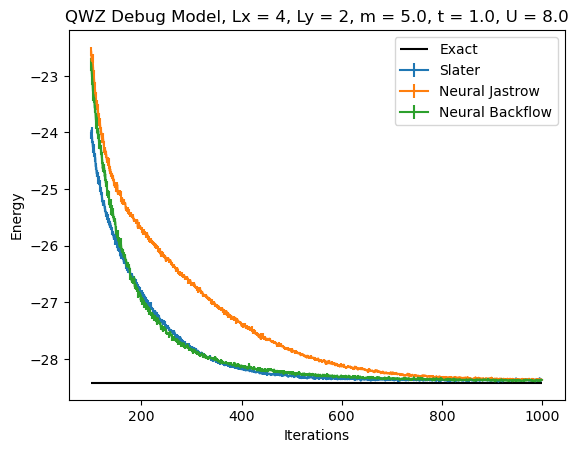

In [21]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

start = 100

end = n_iter

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters[start:end], data["Energy"].Mean.real[start:end], yerr=data["Energy"].Sigma[start:end],label=label)

plt.hlines([E_gs], xmin=start, xmax=end, color='black', label="Exact")
plt.title(f"QWZ Debug Model, Lx = {Lx}, Ly = {Ly}, m = {m}, t = {t}, U = {U}")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

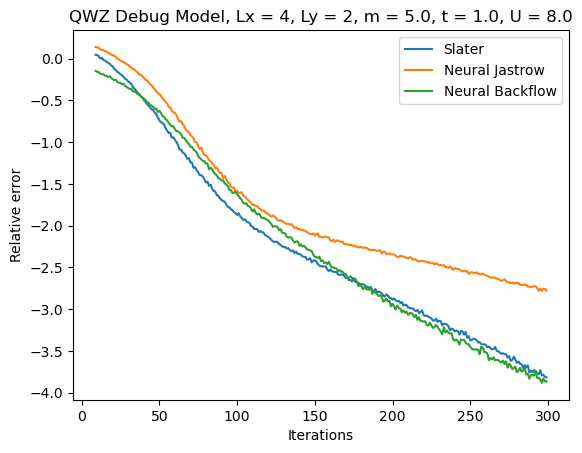

In [22]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

start = 9

end = n_iter

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters[start:end], np.log((data["Energy"].Mean.real[start:end]-E_gs)/abs(E_gs)),label=label)
    
plt.title(f"QWZ Debug Model, Lx = {Lx}, Ly = {Ly}, m = {m}, t = {t}, U = {U}")

plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.legend()